# Federated Learning for Image Classification

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, we will use the image classification task to show how to complete the horizontal federated learning task in the `SecretFlow` framework.
The `SecretFlow` framework provides a user-friendly API that makes it easy to apply your Keras or PyTorch model to a federated learning scenario as a federated learning model.
In the rest of the tutorial we will show you how to turn your existing model into a federated model in `SecretFlow` to complete federated multi-party modeling tasks.

## What is Federated Learning

The federated learning discussed here is specifically focused on horizontal scenarios, where each participant shares the same business but reaches different customer groups. This allows samples from different parties to be combined to train a joint model with improved performance. An example of this scenario can be found in the medical field, where each hospital has its own distinctive patient group and hospitals in different regions largely do not overlap. However, their medical records (such as images and blood tests) for diagnostic purposes are of the same type.

<img alt="federate_learning.png" src="resources/federate_learning.png" width="600">

Training process:  

1. Each participant downloads the latest model from the server.
2. Each participant uses its own local data to train the model, and uploads gradient encryption (or parameter encryption) to the server, which obtains the encryption gradient (encryption parameter) uploaded by all parties for security aggregation at the server, and updates model parameters with the aggregated gradient.
3. The server returns the updated model to each participant.
4. Each participant updates their local model, and prepare next training.

## Federated learning on SecretFlow

In [1]:
%load_ext autoreload
%autoreload 2

Create 3 entities in the Secretflow environment [Alice, Bob, Charlie].
Alice, Bob and Charlie are the three PYUs.
Alice and Bob to be the clients and Charlie to be the server.

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.4.0.dev20240105


2024-01-09 13:05:02,792	INFO worker.py:1538 -- Started a local Ray instance.


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

### Prepare Data

Alice and Bob each own half the data.

In [4]:
from secretflow.data.ndarray import load
from secretflow.utils.simulation.datasets import load_mnist

(x_train, y_train), (x_test, y_test) = load_mnist(
    parts=[alice, bob], normalized_x=True, categorical_y=True
)

`x_train`, `y_train`, `x_test`, `y_test` are both `FedNdarray`. Let's take a look at the data obtained from FedNdarray. FedNdarray is a virtual Ndarray built on a multi-party concept to protect data privacy.
The underlying data is stored in each participant. The FedNdarray operation is actually performed by each participant on their own local data. The server or other clients do not touch the original data.
For demonstration purposes, we will manually download the data to the driver.
**This data will be used later in the unilateral model comparison**.

In [5]:
import numpy as np
from secretflow.utils.simulation.datasets import dataset

mnist = np.load(dataset('mnist'), allow_pickle=True)
image = mnist['x_train']
label = mnist['y_train']

Let's grab some samples from the data set, and just visually see, what does the data look like for Both Alice and Bob?

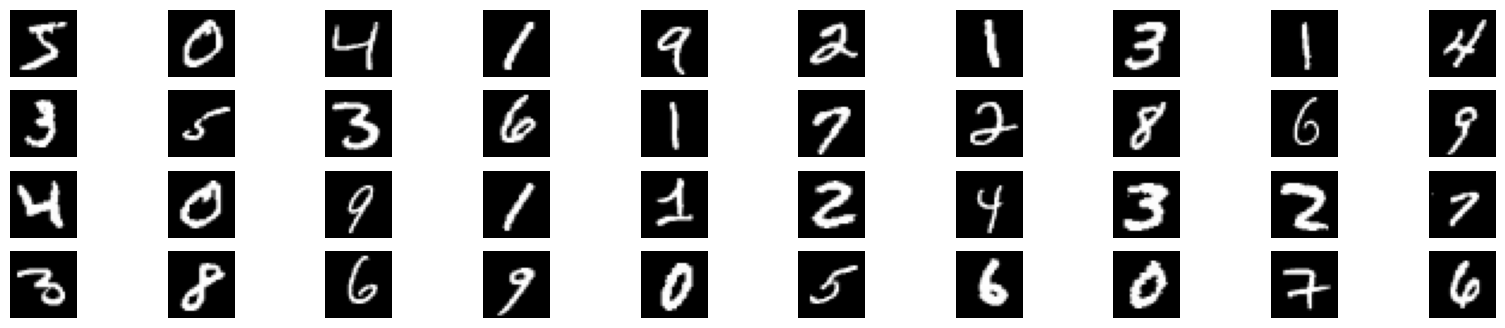

In [6]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20, 4))
j = 0

for example in image[:40]:
    plt.subplot(4, 10, j + 1)
    plt.imshow(example, cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

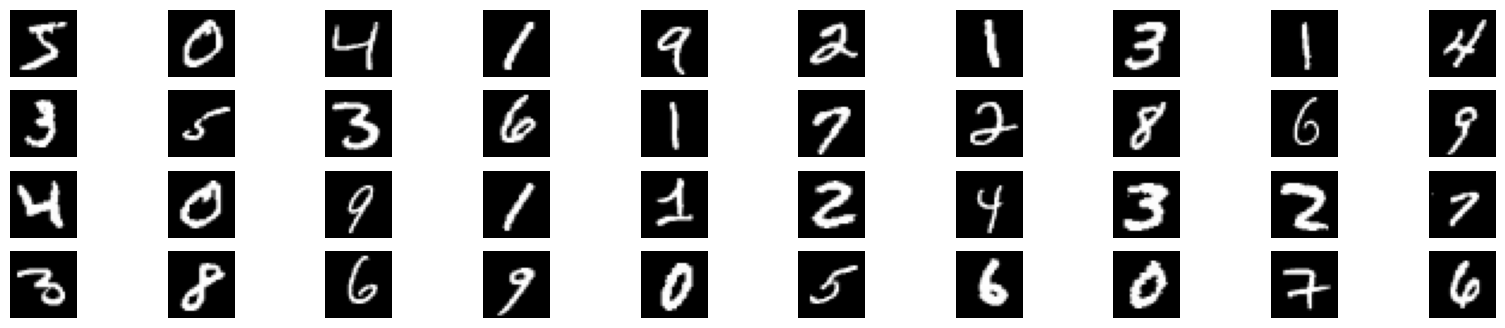

In [7]:
figure = plt.figure(figsize=(20, 4))
j = 0
for example in image[:40]:
    plt.subplot(4, 10, j + 1)
    plt.imshow(example, cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

It can be seen from the above two examples that the data types and tasks of Alice and Bob are consistent, but the samples are different due to the different user groups they reach.

### Define Model

In [8]:
def create_conv_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers

        # Create model
        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        # Compile model
        model.compile(
            loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]
        )
        return model

    return create_model

### Training FL Model

1. Import packages

In [9]:
from secretflow.security.aggregation import SPUAggregator, SecureAggregator
from secretflow.ml.nn import FLModel

2024-01-09 13:34:12.566254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-09 13:34:14.572627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-09 13:34:14.572882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-09 13:34:14.572897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

2. Define Model

In [10]:
num_classes = 10
input_shape = (28, 28, 1)
model = create_conv_model(input_shape, num_classes)

3. Define the device list for participating training, which is the PYUS of each participant prepared previously.

In [11]:
device_list = [alice, bob]

4. Define Aggregator  
The SecretFlow framework provides a variety of aggregation schemes, including `SecureAggregator` and `PPUAggregator`, which can be used for secure aggregation. To learn more information about aggregation, see [Secure Aggregator](../developer/algorithm/secure_aggregation.ipynb).

In [12]:
secure_aggregator = SecureAggregator(charlie, [alice, bob])
spu_aggregator = SPUAggregator(spu)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


5. Define FLModel

In [13]:
fed_model = FLModel(
    server=charlie,
    device_list=device_list,
    model=model,
    aggregator=secure_aggregator,
    strategy="fed_avg_w",
    backend="tensorflow",
)

2024-01-09 13:34:59.315588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-09 13:34:59.315835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-09 13:34:59.315979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-09 13:34:59.316096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-01-09 13:34:59.316253: W tensorfl

6. Lets run model

In [14]:
history = fed_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    sampler_method="batch",
    batch_size=128,
    aggregate_freq=1,
)

(pid=17150) 2024-01-09 13:35:11.809167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d746e2370>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2d746e2580>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d746e2760>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2d746e23a0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d746e29d0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUO

Epoch 1/10


Train Processing: :   0%|          | 1/235 [00:00<00:40,  5.84it/s]

Epoch 2/10


Train Processing: : 100%|█████████▉| 234/235 [00:23<00:00,  9.76it/s, {'loss': 0.15348108, 'accuracy': 0.9547714, 'val_loss': 0.092345044, 'val_accuracy': 0.9732}]
(raylet) [2024-01-09 13:36:02,789 E 4973 4973] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 0366f90ce0f3a02d9f601f4fa3ac5fe53128d3bfd50dc40d9c1156ec, IP: 10.0.0.1) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.1`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY

Epoch 3/10


Train Processing: :   0%|          | 1/235 [00:00<00:37,  6.31it/s]

Epoch 4/10


Train Processing: :   0%|          | 1/235 [00:00<00:39,  5.88it/s]

Epoch 5/10


Train Processing: :   0%|          | 1/235 [00:00<00:37,  6.28it/s]

Epoch 6/10


Train Processing: :   0%|          | 1/235 [00:00<00:36,  6.39it/s]

Epoch 7/10


Train Processing: :   0%|          | 1/235 [00:00<00:39,  5.88it/s]

Epoch 8/10


Train Processing: :   0%|          | 1/235 [00:00<00:38,  6.15it/s]

Epoch 9/10


Train Processing: :   0%|          | 1/235 [00:00<00:40,  5.82it/s]

Epoch 10/10


Train Processing: : 100%|█████████▉| 234/235 [00:32<00:00,  7.17it/s, {'loss': 0.05502795, 'accuracy': 0.98322856, 'val_loss': 0.036154713, 'val_accuracy': 0.988}]


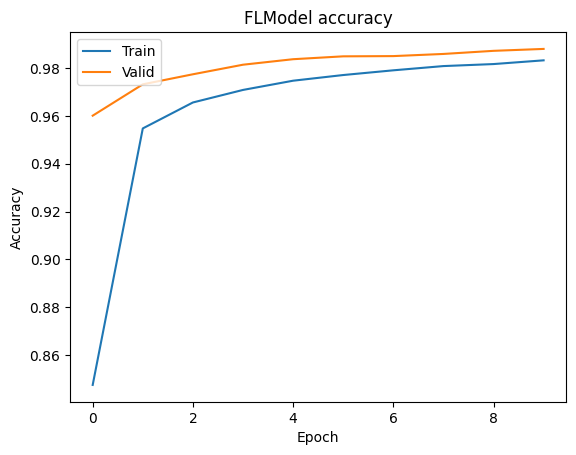

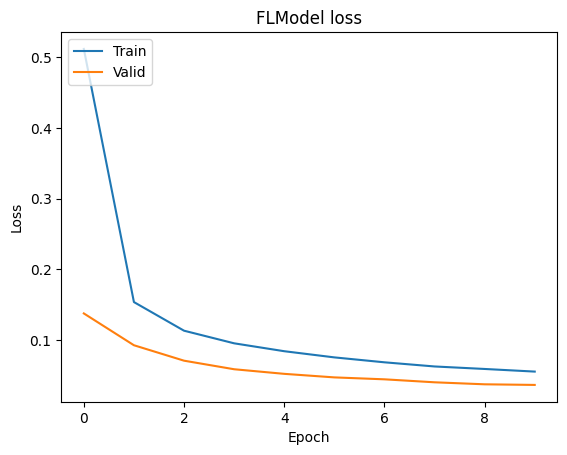

In [15]:
# Draw accuracy values for training & validation
plt.plot(history["global_history"]['accuracy'])
plt.plot(history["global_history"]['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history["global_history"]['loss'])
plt.plot(history["global_history"]['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [16]:
global_metric = fed_model.evaluate(x_test, y_test, batch_size=128)
print(global_metric)

([Mean(name='val_loss', total=361.54712, count=10000.0), Mean(name='val_accuracy', total=9880.0, count=10000.0)], {'alice': [Mean(name='val_loss', total=268.5799, count=5000.0), Mean(name='val_accuracy', total=4906.0, count=5000.0)], 'bob': [Mean(name='val_loss', total=92.96724, count=5000.0), Mean(name='val_accuracy', total=4974.0, count=5000.0)]})


### Contrast experiment to local training

#### Model
The model structure is consistent with the fl model above.


#### Data
Here, we only used data after a horizontal segmentation, with a total of 20,000 samples for `Alice`.

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    # Compile model
    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]
    )
    return model


single_model = create_model()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

alice_x = image[:10000]
alice_y = label[:10000]
alice_y = OneHotEncoder(sparse=False).fit_transform(alice_y.reshape(-1, 1))

random_seed = 1234
alice_X_train, alice_X_test, alice_y_train, alice_y_test = train_test_split(
    alice_x, alice_y, test_size=0.33, random_state=random_seed
)

In [19]:
single_model.fit(
    alice_X_train,
    alice_y_train,
    validation_data=(alice_X_test, alice_y_test),
    batch_size=128,
    epochs=10,
)

Epoch 1/10
53/53 [==============================] - 2s 22ms/step - loss: 5.8566 - accuracy: 0.5737 - val_loss: 0.4520 - val_accuracy: 0.8642
Epoch 2/10
53/53 [==============================] - 1s 17ms/step - loss: 0.6189 - accuracy: 0.8264 - val_loss: 0.2990 - val_accuracy: 0.9070
Epoch 3/10
53/53 [==============================] - 1s 17ms/step - loss: 0.4272 - accuracy: 0.8733 - val_loss: 0.2111 - val_accuracy: 0.9358
Epoch 4/10
53/53 [==============================] - 1s 16ms/step - loss: 0.3308 - accuracy: 0.9027 - val_loss: 0.1857 - val_accuracy: 0.9406
Epoch 5/10
53/53 [==============================] - 1s 16ms/step - loss: 0.2655 - accuracy: 0.9230 - val_loss: 0.1583 - val_accuracy: 0.9497
Epoch 6/10
53/53 [==============================] - 1s 16ms/step - loss: 0.2268 - accuracy: 0.9324 - val_loss: 0.1484 - val_accuracy: 0.9521
Epoch 7/10
53/53 [==============================] - 1s 16ms/step - loss: 0.1994 - accuracy: 0.9354 - val_loss: 0.1340 - val_accuracy: 0.9582
Epoch 8/10
53

The two experiments above simulated a training problem in a typical horizontal federation scenario,  Alice and Bob have same type of data. Each side had only a portion of the sample, but the training objectives is the same. If Alice only uses her own data to train the model, could only obtain a model with an accuracy of 0.945. However, if Bob's data is combined, a model with an accuracy close to 0.995 can be obtained. In addition, the generalization performance of the model jointly trained with multi-party data will also be better.

## Conclusion
* This tutorial introduces what federated learning is and how to perform horizontal federated learning in `secretFlow`.  
* It can be seen from the experimental data that horizontal federation can improve the model effect by expanding the sample size and combining multi-party training.
* This tutorial uses a SecureAggregator to demonstrate, and secretflow provides a variety of aggregation schemes，for more infomation, see [Secure Aggregation](../developer/algorithm/secure_aggregation.ipynb).
* next, you can use your data or model to explore how to do federate learning.
